# **EDA - Análisis Exploratorio de Datos**

**Carga de Bibliotecas y lectura de los datos**

In [15]:
# Instalar librerías si es necesario
# Desinstala cualquier versión incorrecta
#!pip uninstall -y prince

# Instala la versión correcta desde GitHub
#!pip install git+https://github.com/MaxHalford/prince.git



In [80]:

# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
#import prince
from scipy.stats import skew, variation, kstest, shapiro, norm
from sklearn.impute import SimpleImputer


from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


In [81]:
# Leer los datos
airq_dt = pd.read_csv("airq_dt.csv")

# Pasos a realizar:

1. Revisar los datos cargados
2. Analizar los datos categóricos y numéricos
3. Revisar normalidad de los datos
4. Corregir los NAN
5. Corregir los OUTLIERS
6. Escalar


# 1. Revisar los datos cargados


In [82]:
# Dimensiones y vista previa
print(airq_dt.shape)
print()
print(airq_dt.head())
print()
print(airq_dt.info())

(100, 6)

   Ozono  RadSol  Vient  Temp  Mes  Dia
0   21.0   259.0   15.5    76    9   12
1   32.0    92.0   12.0    61    5   24
2   20.0    37.0    9.2    65    6   18
3    NaN   139.0    8.6    82    7   11
4   28.0   273.0   11.5    82    8   13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozono   82 non-null     float64
 1   RadSol  96 non-null     float64
 2   Vient   100 non-null    float64
 3   Temp    100 non-null    int64  
 4   Mes     100 non-null    int64  
 5   Dia     100 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 4.8 KB
None


In [83]:
# Visualizar datos faltantes
print(airq_dt.isnull().sum())


Ozono     18
RadSol     4
Vient      0
Temp       0
Mes        0
Dia        0
dtype: int64



# 2. Analizar los datos categóricos y numéricos


In [84]:
# Diagnóstico de variables categóricas
airq_dt['Mes.ch'] = airq_dt['Mes'].astype(str)
print(airq_dt['Mes.ch'].value_counts())

Mes.ch
8    24
5    22
9    21
7    17
6    16
Name: count, dtype: int64


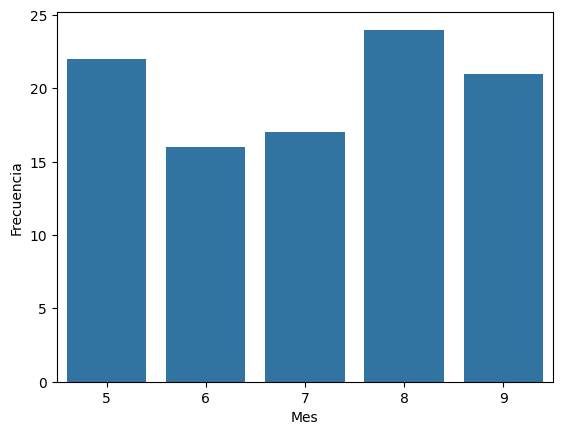

In [85]:
# Gráfico de barras
sns.countplot(x='Mes', data=airq_dt)
plt.xlabel("Mes")
plt.ylabel("Frecuencia")
plt.show()

In [86]:
# Análisis de variables numéricas
print(airq_dt['Ozono'].describe())
print("Coeficiente de asimetría:", skew(airq_dt['Ozono'].dropna()))
print("Coeficiente de variación:", variation(airq_dt['Ozono'].dropna()))

count     82.000000
mean      41.073171
std       35.022314
min        1.000000
25%       16.000000
50%       29.000000
75%       51.500000
max      168.000000
Name: Ozono, dtype: float64
Coeficiente de asimetría: 1.3931633543556752
Coeficiente de variación: 0.8474658192068988



# 3. Revisar normalidad de los datos


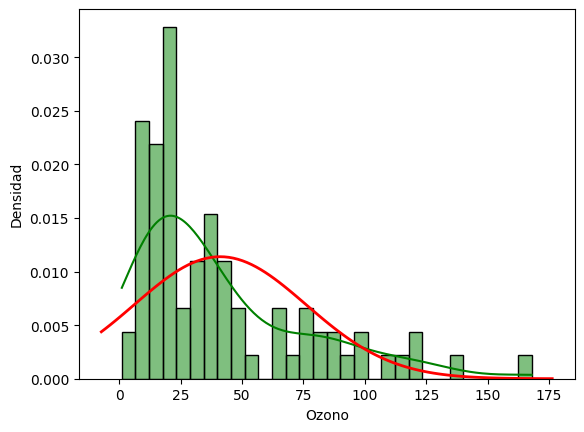

In [87]:
# Histograma con curva de densidad
# Este gráfico muestra la distribución de los valores de ozono, combinando:
# - un histograma normalizado a densidad
# - una curva de densidad empírica (kde)
# - y una curva de densidad teórica normal para comparación visual

# Histograma y densidad empírica (KDE)
sns.histplot(airq_dt['Ozono'].dropna(), kde=True, stat="density", color="green", bins=30)

# Media y desviación estándar de Ozono (usadas para la curva normal teórica)
mean_oz = airq_dt['Ozono'].mean()
std_oz = airq_dt['Ozono'].std()

# Crear rango de valores en el eje X para evaluar la densidad normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Calcular la densidad de la distribución normal con media y desviación estándar calculadas
p = norm.pdf(x, mean_oz, std_oz)

# Agregar la curva normal en rojo
plt.plot(x, p, 'r', linewidth=2)

# Etiquetas y visualización
plt.xlabel("Ozono")
plt.ylabel("Densidad")
plt.show()


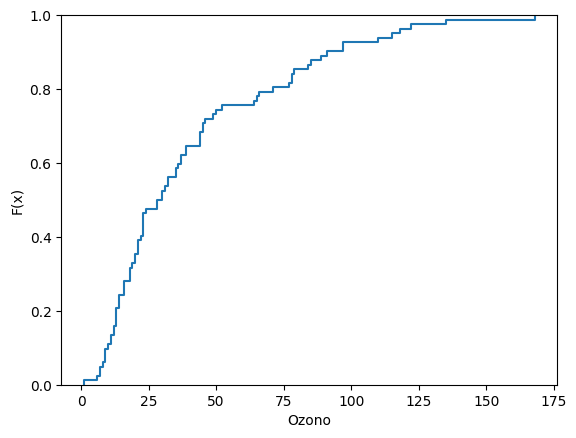

In [88]:
# Distribución empírica acumulada (ECDF)
# Este gráfico muestra la función de distribución acumulada empírica de los valores de ozono.
# Permite visualizar cómo se distribuyen los datos y estimar percentiles visualmente.

# Graficar la ECDF de la variable 'Ozono'
sns.ecdfplot(data=airq_dt, x='Ozono')

# Etiquetas de los ejes
plt.xlabel("Ozono")      # Valores de ozono en el eje X
plt.ylabel("F(x)")       # Probabilidad acumulada en el eje Y

# Mostrar el gráfico
plt.show()


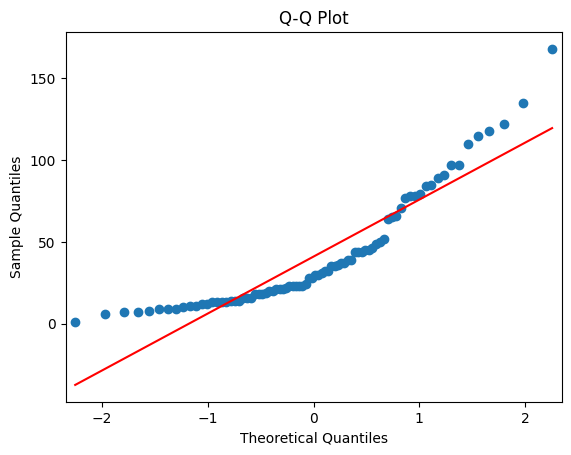

In [89]:
# Q-Q plot (Quantile-Quantile plot)
# Este gráfico compara los cuantiles de la variable 'Ozono' con los cuantiles de una distribución normal.
# Si los datos siguen una distribución normal, los puntos deberían alinearse cerca de la línea diagonal.

# Importar statsmodels para usar la función qqplot
import statsmodels.api as sm

# Crear el gráfico Q-Q usando los datos de Ozono sin valores nulos
# line='s' dibuja una línea de referencia con la misma pendiente y centro que los datos teóricos
sm.qqplot(airq_dt['Ozono'].dropna(), line='s')

# Título del gráfico
plt.title("Q-Q Plot")

# Mostrar el gráfico
plt.show()


In [90]:
# Pruebas de normalidad
# Estas pruebas estadísticas permiten evaluar si los datos siguen una distribución normal.
# Se utilizan para validar supuestos antes de aplicar ciertos métodos estadísticos.

# 1. Kolmogorov-Smirnov (KS) test
# Compara la distribución acumulada empírica de los datos con una distribución teórica (en este caso, normal).
# Ho: los datos siguen una distribución normal con media y desviación estándar dadas
# H1: los datos no siguen esa distribución normal

from scipy.stats import kstest, shapiro

# Parámetros de la distribución normal teórica
mean_oz = airq_dt['Ozono'].mean()
std_oz = airq_dt['Ozono'].std()

# Aplicar KS test a los datos de Ozono
print("KS Test:", kstest(airq_dt['Ozono'].dropna(), 'norm', args=(mean_oz, std_oz)))

# 2. Shapiro-Wilk test para Ozono
# Esta prueba también evalúa la normalidad, pero es más precisa para muestras pequeñas y medianas (< 5000 obs).
# Ho: los datos provienen de una distribución normal
# H1: los datos no provienen de una distribución normal
print("Shapiro Ozono:", shapiro(airq_dt['Ozono'].dropna()))

# 3. Shapiro-Wilk test para la variable Vient
print("Shapiro Vient:", shapiro(airq_dt['Vient'].dropna()))

#Cada una de las pruebas devuelve un estadístico y un valor-p (p-value):

#Si el valor-p > 0.05, no se rechaza la hipótesis nula → los datos podrían ser normales.

#Si el valor-p < 0.05, se rechaza la hipótesis nula → los datos no siguen una distribución normal.

KS Test: KstestResult(statistic=np.float64(0.1699433499657083), pvalue=np.float64(0.01537072655916777), statistic_location=np.float64(39.0), statistic_sign=np.int8(1))
Shapiro Ozono: ShapiroResult(statistic=np.float64(0.8427469223803885), pvalue=np.float64(7.036738454987334e-08))
Shapiro Vient: ShapiroResult(statistic=np.float64(0.9833954264900511), pvalue=np.float64(0.2419978523575051))



# 4. Corregir los NAN


In [91]:
airq_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozono   82 non-null     float64
 1   RadSol  96 non-null     float64
 2   Vient   100 non-null    float64
 3   Temp    100 non-null    int64  
 4   Mes     100 non-null    int64  
 5   Dia     100 non-null    int64  
 6   Mes.ch  100 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 5.6+ KB


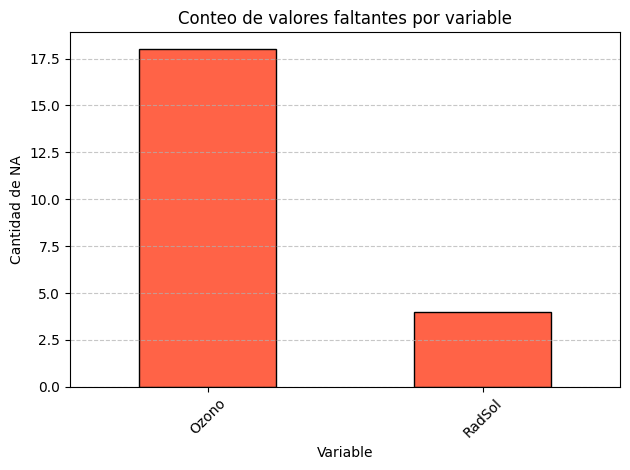

In [92]:
# Gráfico de barras simple para visualizar valores faltantes por variable

# Calcular cantidad de valores nulos por columna
missing_counts = airq_dt.isnull().sum()

# Filtrar solo las columnas con al menos un valor perdido
missing_counts = missing_counts[missing_counts > 0]

# Graficar
missing_counts.plot(kind='bar', color='tomato', edgecolor='black')
plt.title("Conteo de valores faltantes por variable")
plt.ylabel("Cantidad de NA")
plt.xlabel("Variable")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [93]:
# Imputación de datos faltantes por la media (forma recomendada)
# Se crea una nueva columna 'Oz.imp' con los mismos valores de 'Ozono',
# pero reemplazando los NA por la media

airq_dt['Oz.imp'] = airq_dt['Ozono'].fillna(airq_dt['Ozono'].mean())

# Verificar un valor imputado (por ejemplo, fila 4)
print(airq_dt.loc[4, 'Oz.imp'])


28.0


In [94]:
airq_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozono   82 non-null     float64
 1   RadSol  96 non-null     float64
 2   Vient   100 non-null    float64
 3   Temp    100 non-null    int64  
 4   Mes     100 non-null    int64  
 5   Dia     100 non-null    int64  
 6   Mes.ch  100 non-null    object 
 7   Oz.imp  100 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 6.4+ KB


In [95]:
# Imputación múltiple (versión simple usando SimpleImputer con media)
# Este ejemplo aplica imputación por la media a varias columnas del DataFrame.
# Es útil cuando quieres imputar varios campos numéricos de forma consistente.

from sklearn.impute import SimpleImputer

# Seleccionar las primeras 6 columnas del DataFrame
# Puedes ajustar esto según las columnas que realmente quieras imputar
imp_cols = airq_dt.columns[:6]

# Crear un imputador que reemplazará los valores faltantes con la media de cada columna
imp = SimpleImputer(strategy='mean')

# Aplicar la imputación y reconstruir un DataFrame con los mismos nombres de columna
airq_imp_df = pd.DataFrame(imp.fit_transform(airq_dt[imp_cols]), columns=imp_cols)

# Mostrar las primeras filas del nuevo DataFrame imputado
print(airq_imp_df.head())


       Ozono  RadSol  Vient  Temp  Mes   Dia
0  21.000000   259.0   15.5  76.0  9.0  12.0
1  32.000000    92.0   12.0  61.0  5.0  24.0
2  20.000000    37.0    9.2  65.0  6.0  18.0
3  41.073171   139.0    8.6  82.0  7.0  11.0
4  28.000000   273.0   11.5  82.0  8.0  13.0


In [96]:
airq_imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozono   100 non-null    float64
 1   RadSol  100 non-null    float64
 2   Vient   100 non-null    float64
 3   Temp    100 non-null    float64
 4   Mes     100 non-null    float64
 5   Dia     100 non-null    float64
dtypes: float64(6)
memory usage: 4.8 KB




# 5. Corregir los OUTLIERS



In [97]:
# Detección de valores atípicos usando el criterio del rango intercuartil (IQR)
# Este método es útil para identificar datos extremos sin asumir una distribución específica.

# 1. Calcular el primer cuartil (Q1) → 25% de los datos están por debajo de este valor
Q1 = airq_dt['Ozono'].quantile(0.25)

# 2. Calcular el tercer cuartil (Q3) → 75% de los datos están por debajo de este valor
Q3 = airq_dt['Ozono'].quantile(0.75)

# 3. Calcular el rango intercuartil (IQR) → Q3 - Q1
IQR = Q3 - Q1

# 4. Definir los límites para detectar outliers:
# - Límite inferior (LI): Q1 - 1.5 * IQR
# - Límite superior (LS): Q3 + 1.5 * IQR
LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR

# 5. Identificar los valores atípicos:
# - Valores por encima del límite superior
outliers_sup = airq_dt['Ozono'] >= LS

# - Valores por debajo del límite inferior
outliers_inf = airq_dt['Ozono'] <= LI

# 6. Imprimir los valores detectados como atípicos
print("Valores atípicos superiores:", airq_dt['Ozono'][outliers_sup])
print("Valores atípicos inferiores:", airq_dt['Ozono'][outliers_inf])


Valores atípicos superiores: 15    118.0
20    110.0
51    135.0
56    115.0
66    122.0
91    168.0
Name: Ozono, dtype: float64
Valores atípicos inferiores: Series([], Name: Ozono, dtype: float64)


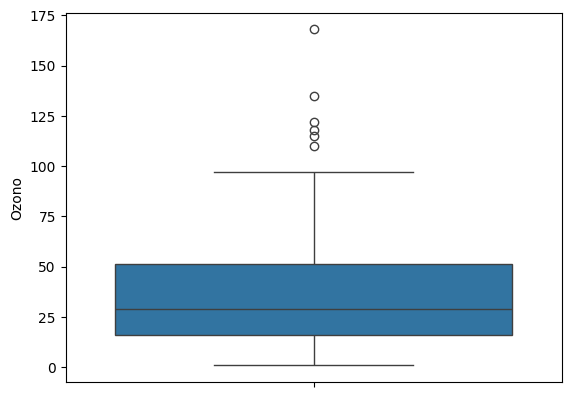

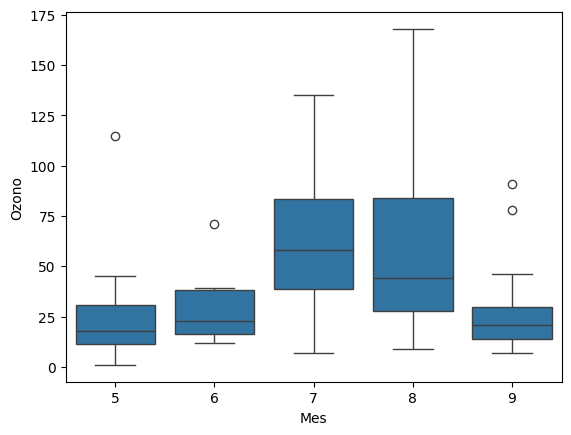

In [56]:
# Boxplot general y por mes
sns.boxplot(y='Ozono', data=airq_dt)
plt.show()
sns.boxplot(x='Mes', y='Ozono', data=airq_dt)
plt.show()

✅ No quedaron outliers (según el criterio IQR).


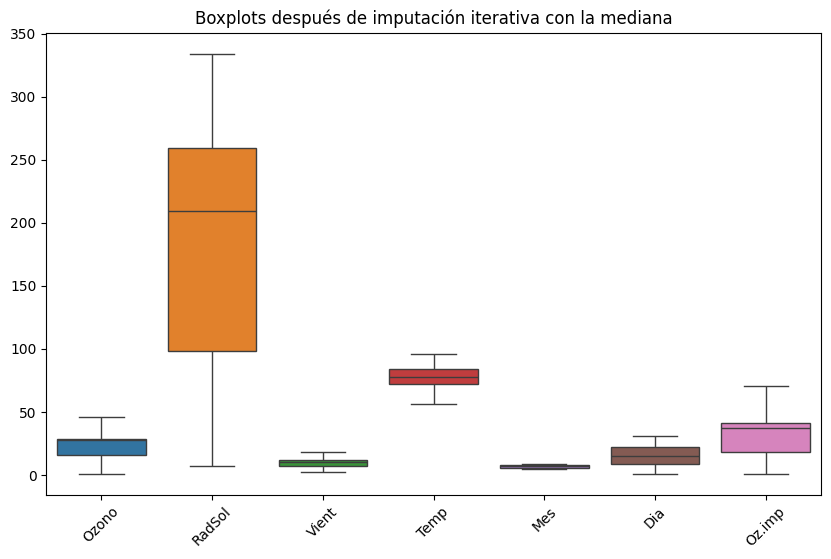

In [98]:
# ================================================================
# Corrección de outliers usando Q1, Q3, IQR y límites LI/LS ya calculados

# ================================================================


df_final = airq_dt.copy()

# ====================================================
# Imputación iterativa de outliers en TODAS las variables numéricas
# hasta que no queden outliers (usando la mediana)
# ====================================================

df_final = df_limpio.copy()
cols_num = df_final.select_dtypes(include='number').columns

cambio = True
while cambio:
    cambio = False
    for col in cols_num:
        q1 = df_final[col].quantile(0.25)
        q3 = df_final[col].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        mask = (df_final[col] < low) | (df_final[col] > high)
        if mask.sum() > 0:
            mediana = df_final[col].median()
            df_final.loc[mask, col] = mediana
            cambio = True

print("✅ No quedaron outliers (según el criterio IQR).")

# Boxplot final
plt.figure(figsize=(10,6))
sns.boxplot(data=df_final[cols_num])
plt.title("Boxplots después de imputación iterativa con la mediana")
plt.xticks(rotation=45)
plt.show()





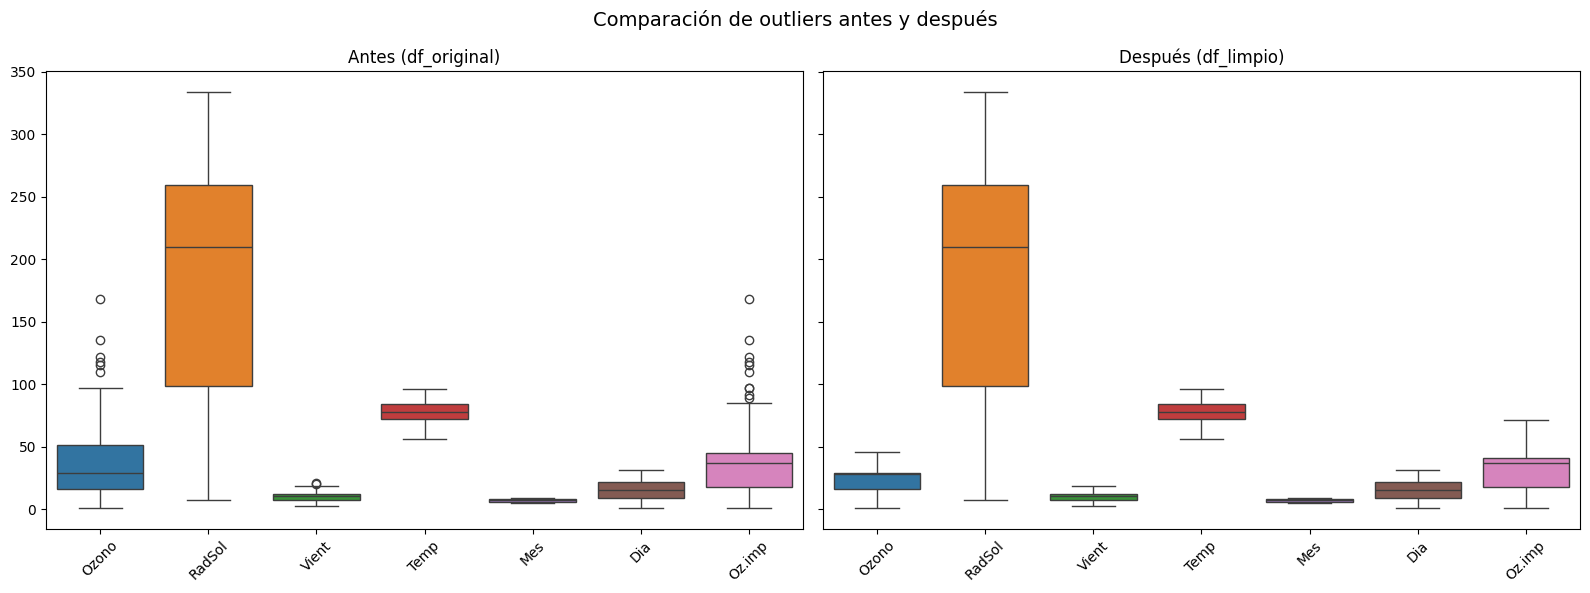

In [99]:
# ====================================================
# Boxplots comparativos: antes vs después de limpiar
# ====================================================


# Solo columnas numéricas
num_cols = df_final.select_dtypes(include='number').columns

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# Boxplot antes (df_original)
sns.boxplot(data=airq_dt[num_cols], ax=axes[0])
axes[0].set_title("Antes (df_original)")
axes[0].tick_params(axis='x', rotation=45)

# Boxplot después (df_limpio)
sns.boxplot(data=df_final[num_cols], ax=axes[1])
axes[1].set_title("Después (df_limpio)")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Comparación de outliers antes y después", fontsize=14)
plt.tight_layout()
plt.show()




# 6. Escalar

In [102]:
# ====================================================
# Eliminar la variable 'Ozono' y escalar todo el DataFrame
# ====================================================


# Copia del df_final y eliminar la variable 'Ozono' y 'Mes.ch'
#
df_scaled = df_final.drop(columns=['Ozono', 'Mes.ch']).copy()

# Seleccionar solo columnas numéricas
num_cols = df_scaled.select_dtypes(include='number').columns

# Escalar con StandardScaler
scaler = StandardScaler()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

print("✅ DataFrame sin escalado con la variable 'Ozono'.")
display(df_final.head())

print("✅ DataFrame escalado sin la variable 'Ozono'.")
display(df_scaled.head())

✅ DataFrame sin escalado con la variable 'Ozono'.


,Ozono,RadSol,Vient,Temp,Mes,Dia,Mes.ch,Oz.imp
0,21.0,259.0,15.5,76,9,12,9,21.000000
1,32.0,92.0,12.0,61,5,24,5,32.000000
2,20.0,37.0,9.2,65,6,18,6,20.000000
3,NaN,139.0,8.6,82,7,11,7,41.073171
4,28.0,273.0,11.5,82,8,13,8,28.000000


✅ DataFrame escalado sin la variable 'Ozono'.


,RadSol,Vient,Temp,Mes,Dia,Oz.imp
0,0.778114,1.604962,-0.158860,1.333530,-0.406293,-0.672159
1,-0.989344,0.582879,-1.726561,-1.416017,1.031912,0.085151
2,-1.571441,-0.234787,-1.308507,-0.728630,0.312810,-0.741005
3,-0.491916,-0.410001,0.468220,-0.041243,-0.526143,0.709806
4,0.926284,0.436867,0.468220,0.646143,-0.286442,-0.190234
